Założenia:

1. Wybieramy temat. Może być to temat z poprzedniego projektu – o ile nie będzie realizować tego samego lub podobnego projektu trzeci raz.
2. Wyznaczamy zmienną celu.
3. Dokonujemy eksploracji zbioru. Uzupełniamy braki danych. Dokonujemy wstępnej selekcji zmiennych.
4. Dzielimy zbiór danych na treningowy testowy i w miarę możliwości na walidacyjny.
5. Tworzymy różnego rodzaju modele sieci neuronowych – sprawdzając różne możliwe parametry.
6. Porównujemy i wybieramy najlepszy model.
7. Dokonujemy ostatecznej oceny wybranego modelu na zbiorze walidacyjnym.
8. Porównujemy rozwiązanie z przynajmniej jednym, poznanym modelem w bloku ML.
9. Wskazujemy uzysk dla firmy / odbiorcy (np. ile pieniędzy z tego będzie miała, jak wdrożenie wpłynie na rozpoznawalność przypadków, dla których firma wykona działania prewencyjne itd.) – to jest bardzo ważny punkt.
10. Budujemy aplikację wykorzystującą model.
11. Na prezentacji powinna znaleźć się krótka analiza zmiennych, omówienie wyników wszystkich zastosowanych technik modelowania i ich porównanie, wybór modelu i przede wszystkim wartość dodana jaką niesie za sobą wdrożenie.

7. Sortownia owoców
* Klasyfikacja jabłek
* aplikacja na taśmie w fabryce dżemów
* typ zadania: klasyfikacja zdjęć
* wersja podstawowa: trzy klasy silnie odróżniające się od siebie
* wersja zaawansowana: wszystkie klasy
* https://www.kaggle.com/chrisfilo/fruit-recognition


In [194]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_fscore_support
import cv2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
import datetime
import os
import seaborn as sns
import glob
from sklearn.utils import shuffle
# import tensorflow.keras.layers as L
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, plot_roc_curve, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
import seaborn as sns
import warnings

In [127]:
# for dirname, _, filenames in os.walk('data'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

In [128]:
def printmd(string):   
    display(Markdown(string))
    
np.random.seed(123) # Add random seed of training for reproducibility

def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [129]:
images = []
dirp = "data/Apple/"
for e in os.listdir(dirp):
    if e == "Apple A":
        images += load_images_from_folder(dirp+"/"+e,True,label = "Apple A")
    elif e == "Apple B":
        images += load_images_from_folder(dirp+"/"+e,True,label = "Apple B")
    elif e == "Apple C":
        images += load_images_from_folder(dirp+"/"+e,True,label = "Apple A")
    elif e == "Apple D":
        images += load_images_from_folder(dirp+"/"+e,True,label = "Apple C")
    elif e == "Apple E":
        images += load_images_from_folder(dirp+"/"+e,True,label = "Apple A")
    elif e == "Apple F":
        images += load_images_from_folder(dirp+"/"+e,True,label = "Apple C")


In [130]:
data_df = pd.DataFrame(images, columns = ["fruit", "path"])

data_df = shuffle(data_df, random_state = 123)
data_df = data_df.reset_index(drop=True)

fruit_names = sorted(data_df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
data_df["label"] = data_df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

# data_df

{'Apple A': 0, 'Apple B': 1, 'Apple C': 2}


fruit                                           path  label
0     Apple B  data/Apple//Apple B\595red applee07301595.png      1
1     Apple C              data/Apple//Apple F\Apple F85.png      2
2     Apple A             data/Apple//Apple E\Apple E217.png      0
3     Apple A             data/Apple//Apple E\Apple E103.png      0
4     Apple C         data/Apple//Apple D\Apple dee04881.png      2
...       ...                                            ...    ...
6156  Apple C             data/Apple//Apple F\Apple F324.png      2
6157  Apple A          data/Apple//Apple E\Apple Ee02041.png      0
6158  Apple B             data/Apple//Apple B\scene04726.png      1
6159  Apple C             data/Apple//Apple D\scene03376.png      2
6160  Apple A           data/Apple//Apple E\Apple E06116.png      0

[6161 rows x 3 columns]

In [131]:
data_df.groupby('fruit').count()

path  label
fruit               
Apple A  2358   2358
Apple B   740    740
Apple C  3063   3063

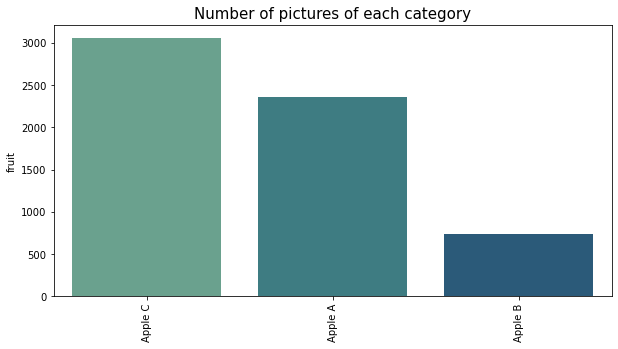

In [132]:
fc = data_df["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = fc.index, y = fc, palette = "crest")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [133]:
# w celu testowania modeli zmniejszam zbiór do 100 próbek z kazdej kategorii
num_patterns = 100
img_simp_ds = pd.DataFrame()
for fr in data_df['fruit'].unique():
    img_simp_ds = img_simp_ds.append(data_df[data_df['fruit']==fr][0:num_patterns], ignore_index=True)
print(img_simp_ds.count())
model_data = img_simp_ds

fruit    300
path     300
label    300
dtype: int64


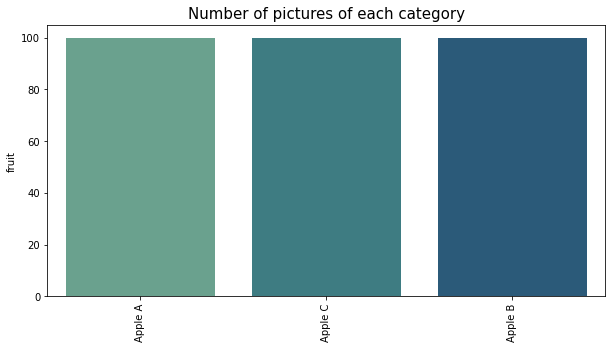

In [134]:
fc = model_data["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = fc.index, y = fc, palette = "crest")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

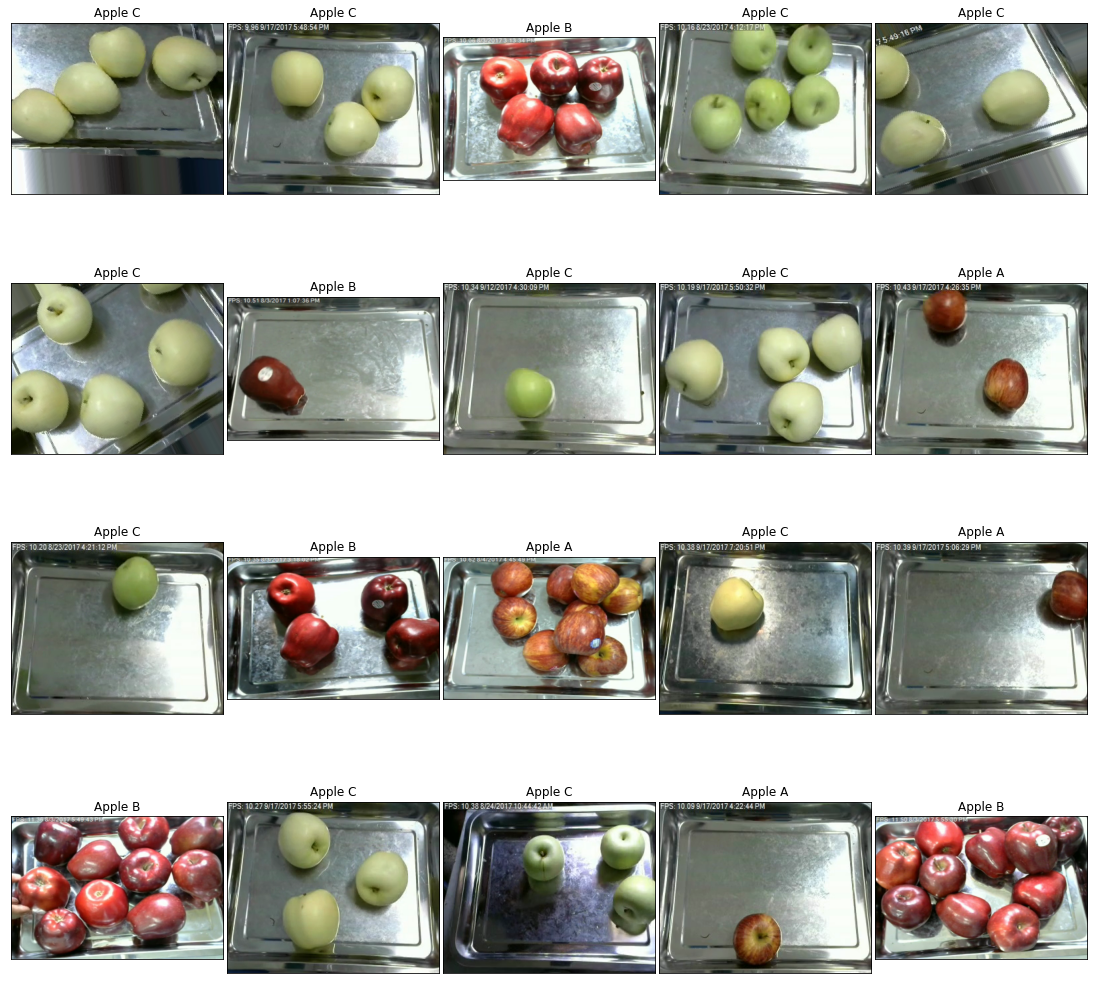

In [135]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data_df.path[i+20]))
    ax.set_title(data_df.fruit[i+20], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

In [136]:
# wszystkie zdjecia w takim samym rozmiarze
x = []
for i in range(len(model_data.path)):
    img = plt.imread(model_data.path[i])
    img = cv2.resize(img, (224,224))
    x.append(img)

In [137]:
# image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
#                                width_shift_range=0.10, # Shift the pic width by a max of 5%
#                                height_shift_range=0.10, # Shift the pic height by a max of 5%
#                                rescale=1/255, # Rescale the image by normalzing it.
#                                shear_range=0.1, # Shear means cutting away part of the image (max 10%)
#                                zoom_range=0.1, # Zoom in by 10% max
#                                horizontal_flip=True, # Allo horizontal flipping
#                                fill_mode='nearest' # Fill in missing pixels with the nearest filled value
#                               )

In [138]:
# image_gen.flow_from_directory(data_df['path'])

In [139]:
x = np.array(x)
x.shape

(300, 224, 224, 3)

In [140]:
y = np.array(model_data['label'])

In [141]:
y.shape

(300,)

In [142]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [143]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

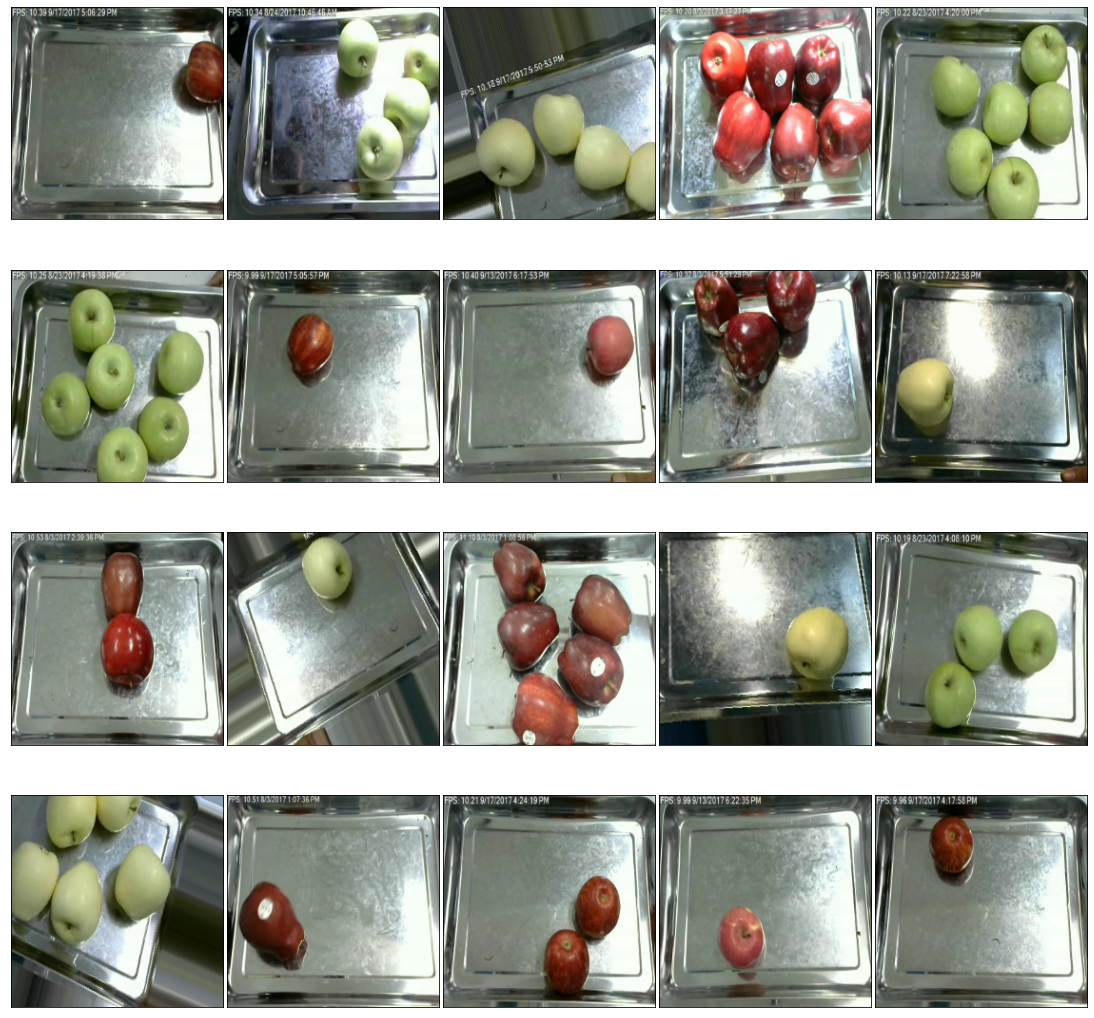

In [144]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])
    # ax.set_title(y_train[i+20], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

In [145]:
# transformujemy y_test
y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()
# podglądamy
y_test = y_test.astype(np.float32)

# transformujemy y_train
y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1)).toarray()
# podglądamy
y_train = y_train.astype(np.float32)

print("y_test.shape: ", y_test.shape)
print("y_train.shape: ", y_train.shape)


y_test.shape:  (60, 3)
y_train.shape:  (240, 3)


In [182]:
# y_train

In [147]:
# zmieniamy shape pod konwolucje
x_test = x_test.reshape(-1,224,224,3)
x_train = x_train.reshape(-1,224,224,3)

In [148]:
x_train.shape[0]%30

0

In [149]:
model_1 = tf.keras.Sequential()
model_1.add(layers.Conv2D(32,kernel_size=3,strides=1, activation='relu',padding='same',input_shape=x_train.shape[1:]))
model_1.add(layers.MaxPooling2D((2,2),strides=2,padding="SAME"))
model_1.add(layers.Conv2D(64,kernel_size=3,strides=1, activation='relu',padding='same'))
model_1.add(layers.Conv2D(64,kernel_size=3,strides=1, activation='relu',padding='same'))
model_1.add(layers.MaxPooling2D((2,2),strides=2,padding="SAME"))
model_1.add(layers.Conv2D(128,kernel_size=3,strides=1, activation='relu',padding='same'))
model_1.add(layers.Conv2D(128,kernel_size=3,strides=1, activation='relu',padding='same'))
model_1.add(layers.MaxPooling2D((2,2),strides=2,padding="SAME"))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(512,activation='relu'))
model_1.add(layers.Dropout(0.2))
model_1.add(layers.Dense(3,activation='softmax'))
model_1.summary()

opt = tf.keras.optimizers.Adam()
loss=tf.keras.losses.CategoricalCrossentropy()

model_1.compile(optimizer=opt,loss=loss,metrics=["accuracy"])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 56, 56, 128)      

In [151]:
history_1=model_1.fit(x=x_train,y=y_train,epochs=50,batch_size=30, validation_split=0.05)

Epoch 1/50
8/8 [==============================] - 17s 2s/step - loss: 0.5789 - accuracy: 0.7763 - val_loss: 0.2776 - val_accuracy: 0.8333
Epoch 2/50
8/8 [==============================] - 16s 2s/step - loss: 0.2841 - accuracy: 0.8904 - val_loss: 0.0804 - val_accuracy: 1.0000
Epoch 3/50
8/8 [==============================] - 16s 2s/step - loss: 0.1735 - accuracy: 0.9254 - val_loss: 0.0631 - val_accuracy: 1.0000
Epoch 4/50
8/8 [==============================] - 16s 2s/step - loss: 0.0951 - accuracy: 0.9605 - val_loss: 0.2230 - val_accuracy: 0.9167
Epoch 5/50
8/8 [==============================] - 16s 2s/step - loss: 0.0812 - accuracy: 0.9737 - val_loss: 0.0290 - val_accuracy: 1.0000
Epoch 6/50
8/8 [==============================] - 16s 2s/step - loss: 0.1030 - accuracy: 0.9430 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 7/50
8/8 [==============================] - 16s 2s/step - loss: 0.2325 - accuracy: 0.9254 - val_loss: 0.4044 - val_accuracy: 0.9167
Epoch 8/50
8/8 [==================

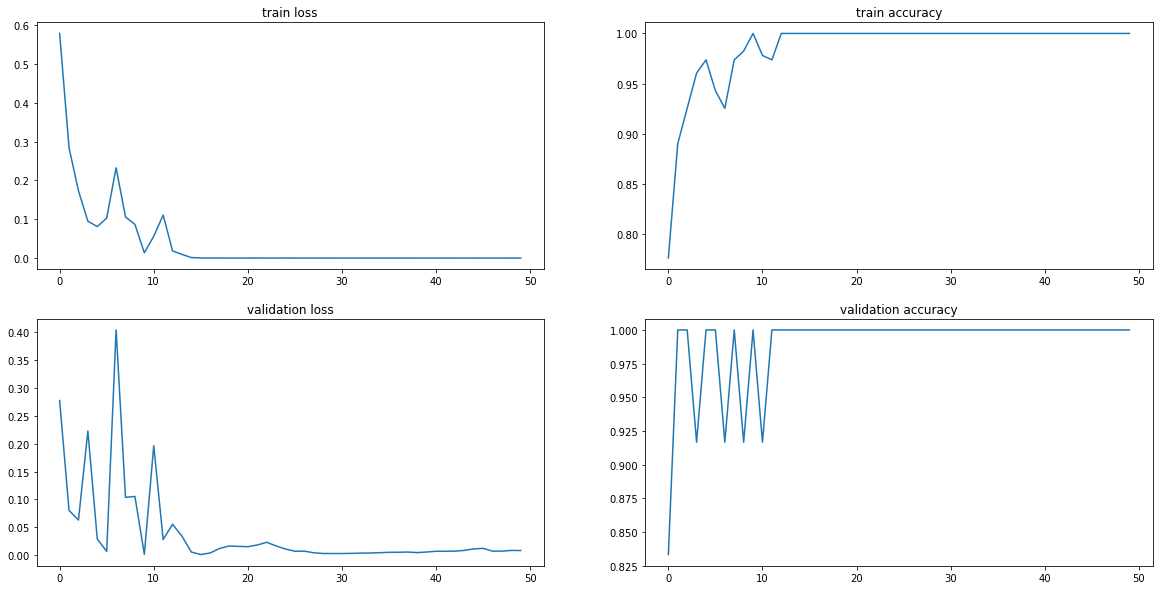

              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.96      1.00      0.98        23
           2       0.94      0.94      0.94        17

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60

(array([0.94736842, 0.95833333, 0.94117647]), array([0.9       , 1.        , 0.94117647]), array([0.92307692, 0.9787234 , 0.94117647]), array([20, 23, 17], dtype=int64))


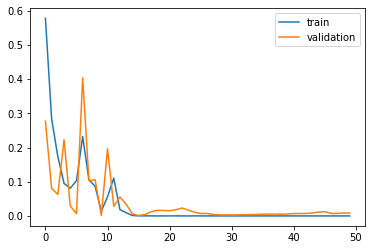

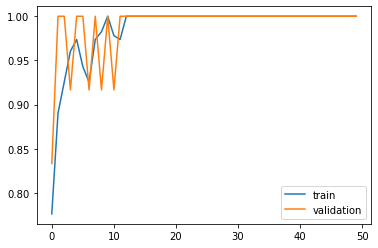

In [152]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history_1.history["loss"])
ax[0][1].plot(history_1.history["accuracy"])
ax[1][0].plot(history_1.history["val_loss"])
ax[1][1].plot(history_1.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

# testowanie
y_pred = model_1.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(precision_recall_fscore_support(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])
plt.legend(["train", "validation"])
plt.show()

plt.plot(history_1.history["accuracy"])
plt.plot(history_1.history["val_accuracy"])
plt.legend(["train", "validation"])
plt.show()

In [153]:
def create_cnn_model(inShape, convNum, hNum, hAct, outNum, loss):
    """
    :param inShape: kształt wejścia, h*w*c
    :param convNum: lista ilości featerów w warstwach konwolucyjnych
    :param hNum: lista ilości neuronów w poszczególnych warstwach ukrytych
    :param hAct: rodzaj aktywacji w warstwach ukrytych, str
    :param outNum: ilość neutronów
    :param loss: funkcja kosztu
    """
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(inShape)))
    for idx, oneConvNum in enumerate(convNum):
        model.add(layers.Conv2D(filters=oneConvNum,kernel_size=3,strides=1,padding="SAME",activation="relu"))
        model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2,padding="SAME" ))
    model.add(layers.Flatten())
    for idx, oneHidNum in enumerate(hNum):
        model.add(layers.Dense(oneHidNum, activation=hAct))
    model.add(layers.Dense(outNum))
    model.add(layers.Softmax())
    print(model.summary())
    
    opt = tf.keras.optimizers.Adam()
    
    model.compile(optimizer=opt,loss=loss,metrics=["accuracy"])
    
    return model

In [154]:
modelCNN = create_cnn_model(
    inShape=x_train.shape[1:],
    convNum=[32,64,128, 256],
    hNum=[50],
    hAct="relu",
    outNum=3,
    loss=tf.keras.losses.CategoricalCrossentropy()
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 28, 28, 256)      

In [155]:
history_2 = modelCNN.fit(
    x=x_train,
    y=y_train,
    batch_size=30,
    epochs=50,
    validation_split=0.05
)

Epoch 1/50
8/8 [==============================] - 10s 1s/step - loss: 1.3135 - accuracy: 0.2982 - val_loss: 1.0702 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 9s 1s/step - loss: 0.9955 - accuracy: 0.5307 - val_loss: 1.0072 - val_accuracy: 0.6667
Epoch 3/50
8/8 [==============================] - 9s 1s/step - loss: 0.7817 - accuracy: 0.5965 - val_loss: 0.5185 - val_accuracy: 0.8333
Epoch 4/50
8/8 [==============================] - 8s 1s/step - loss: 0.5260 - accuracy: 0.7763 - val_loss: 0.2955 - val_accuracy: 1.0000
Epoch 5/50
8/8 [==============================] - 9s 1s/step - loss: 0.3351 - accuracy: 0.8684 - val_loss: 0.1433 - val_accuracy: 0.9167
Epoch 6/50
8/8 [==============================] - 9s 1s/step - loss: 0.2446 - accuracy: 0.9079 - val_loss: 0.0599 - val_accuracy: 1.0000
Epoch 7/50
8/8 [==============================] - ETA: 0s - loss: 0.1873 - accuracy: 0.93 - 9s 1s/step - loss: 0.1873 - accuracy: 0.9342 - val_loss: 0.1315 - val_accuracy: 1.000

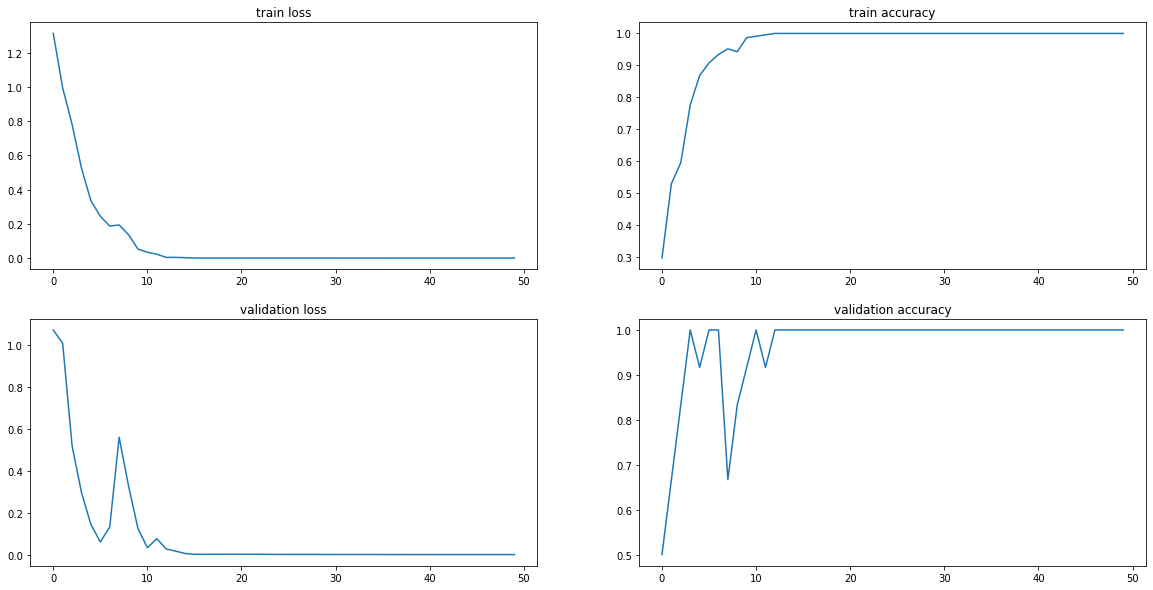

              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.96      0.96      0.96        23
           2       0.94      1.00      0.97        17

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60

(array([0.94736842, 0.95652174, 0.94444444]), array([0.9       , 0.95652174, 1.        ]), array([0.92307692, 0.95652174, 0.97142857]), array([20, 23, 17], dtype=int64))


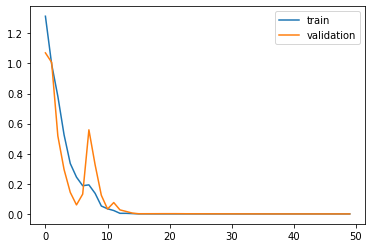

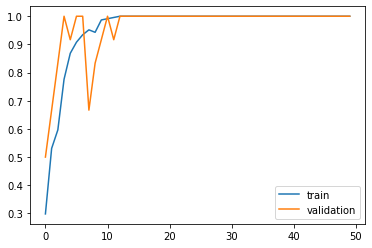

In [156]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history_2.history["loss"])
ax[0][1].plot(history_2.history["accuracy"])
ax[1][0].plot(history_2.history["val_loss"])
ax[1][1].plot(history_2.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

# testowanie
y_pred = modelCNN.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(precision_recall_fscore_support(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.legend(["train", "validation"])
plt.show()

plt.plot(history_2.history["accuracy"])
plt.plot(history_2.history["val_accuracy"])
plt.legend(["train", "validation"])
plt.show()

In [157]:
def create_cnn_model_2(inShape, convNum, hNum, hAct, outNum, loss):
    """
    :param inShape: kształt wejścia, h*w*c
    :param convNum: lista ilości featerów w warstwach konwolucyjnych
    :param hNum: lista ilości neuronów w poszczególnych warstwach ukrytych
    :param hAct: rodzaj aktywacji w warstwach ukrytych, str
    :param outNum: ilość neuronów
    :param loss: funkcja kosztu
    """
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(inShape)))
    for idx, oneConvNum in enumerate(convNum):
        model.add(layers.Conv2D(filters=oneConvNum,kernel_size=3,strides=1,padding="SAME",activation="relu"))
        model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2,padding="SAME"))
    model.add(layers.Flatten())
    for idx, oneHidNum in enumerate(hNum):
        model.add(layers.Dense(oneHidNum, activation=hAct))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(outNum,activation='softmax'))
    print(model.summary())
    
    opt = tf.keras.optimizers.Adam()
    
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=["accuracy"]
    )
    
    return model

In [158]:
modelCNN_2 = create_cnn_model_2(
    inShape=x_train.shape[1:],
    convNum=[32,64,128],
    hNum=[100],
    hAct="relu",
    outNum=3,
    loss=tf.keras.losses.CategoricalCrossentropy()
)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 100352)           

In [159]:
history_3 = modelCNN_2.fit(
    x=x_train,
    y=y_train,
    batch_size=30,
    epochs=50,
    validation_split=0.05
)

Epoch 1/50
8/8 [==============================] - 14s 868ms/step - loss: 1.5853 - accuracy: 0.4386 - val_loss: 0.7338 - val_accuracy: 0.7500
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 0.7095 - accuracy: 0.67 - 7s 804ms/step - loss: 0.7095 - accuracy: 0.6754 - val_loss: 0.3742 - val_accuracy: 0.9167
Epoch 3/50
8/8 [==============================] - 7s 834ms/step - loss: 0.3401 - accuracy: 0.8860 - val_loss: 0.1434 - val_accuracy: 1.0000
Epoch 4/50
8/8 [==============================] - 7s 832ms/step - loss: 0.1436 - accuracy: 0.9518 - val_loss: 0.2105 - val_accuracy: 0.8333
Epoch 5/50
8/8 [==============================] - 7s 841ms/step - loss: 0.1168 - accuracy: 0.9561 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 6/50
8/8 [==============================] - 7s 836ms/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/50
8/8 [==============================] - 7s 833ms/step - loss: 0.0348 - accuracy: 0.9912 - val_loss: 0.0131 

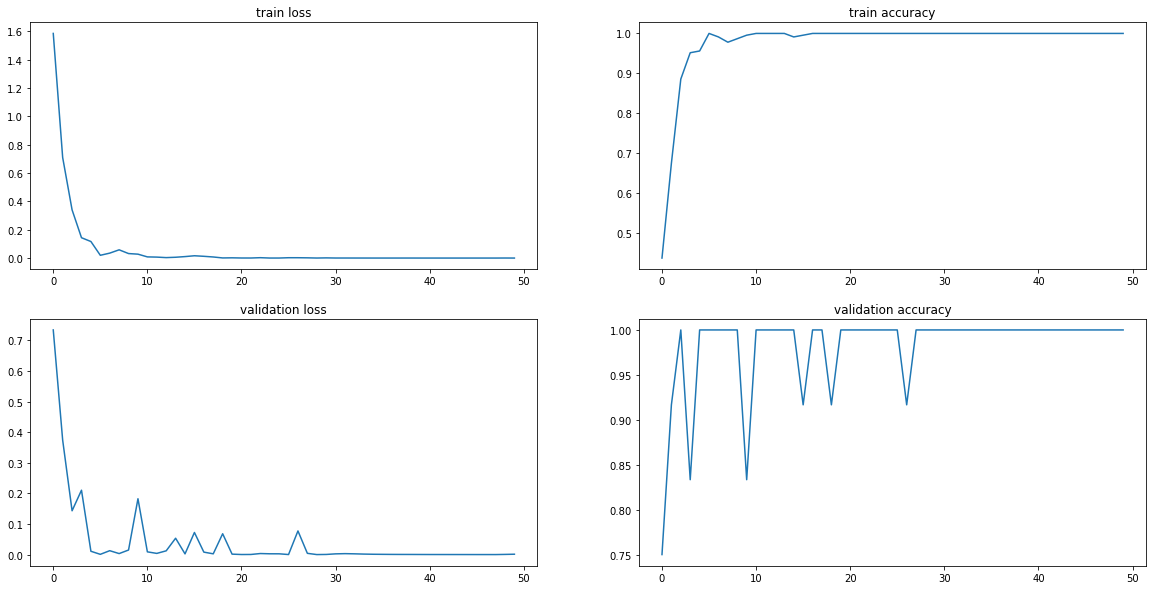

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        17

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        17

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

(array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([20, 23, 17], dtype=int64))


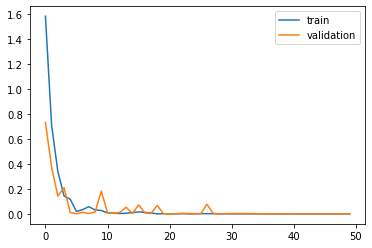

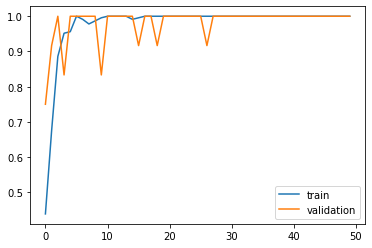

In [160]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history_3.history["loss"])
ax[0][1].plot(history_3.history["accuracy"])
ax[1][0].plot(history_3.history["val_loss"])
ax[1][1].plot(history_3.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

# testowanie
y_pred = modelCNN_2.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(precision_recall_fscore_support(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

plt.plot(history_3.history["loss"])
plt.plot(history_3.history["val_loss"])
plt.legend(["train", "validation"])
plt.show()

plt.plot(history_3.history["accuracy"])
plt.plot(history_3.history["val_accuracy"])
plt.legend(["train", "validation"])
plt.show()

In [161]:
# wejście
inputLayer = tf.keras.Input(shape=(x_train.shape[1:]))

In [162]:
MobileNetV2_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
DenseNet121_model = tf.keras.applications.DenseNet121(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
MobileNet_model = tf.keras.applications.MobileNet(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
Xception1_model = tf.keras.applications.Xception(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
DenseNet169_model = tf.keras.applications.DenseNet169(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)

models = [MobileNetV2_model,DenseNet121_model,MobileNet_model,Xception1_model,DenseNet169_model]

In [163]:
for model in models:
    model.trainable = False

In [164]:
x_train.shape[1:]

(224, 224, 3)

In [53]:
m = MobileNetV2_model(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.2)(m)
output = layers.Dense(3)(m)
MobileNetV2_model = tf.keras.Model(inputLayer, output)
MobileNetV2_model.summary()
# kompilujemy całość
MobileNetV2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"],)
# trening z podaniem callbacków
history_4 = MobileNetV2_model.fit(x=x_train,y=y_train,batch_size=30,epochs=10,validation_split=0.05)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 17)                21777     
Total params: 2,279,761
Trainable params: 21,777
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10
8/8 [==============================] - 79s 6s/step - loss: 0.5715 - accuracy: 0.1146 - val_loss: 0.

In [165]:
m = DenseNet121_model(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.2)(m)
output = layers.Dense(3)(m)
DenseNet121_model = tf.keras.Model(inputLayer, output)
DenseNet121_model.summary()
# kompilujemy całość
DenseNet121_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"],)
# trening z podaniem callbacków
history_5 = DenseNet121_model.fit(x=x_train,y=y_train,batch_size=30,epochs=10,validation_split=0.05)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_12  (None, 1024)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/10
8/8 [==============================] - 21s 2s/step - loss: 0.6347 - accuracy: 0.7544 - val_loss: 0.

In [166]:
m = MobileNet_model(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.2)(m)
output = layers.Dense(3)(m)
MobileNet_model = tf.keras.Model(inputLayer, output)
MobileNet_model.summary()
# kompilujemy całość
MobileNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"],)
# trening z podaniem callbacków
history_6 = MobileNet_model.fit(x=x_train,y=y_train,batch_size=30,epochs=10,validation_split=0.05)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_13  (None, 1024)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,075
Non-trainable params: 3,228,864
_________________________________________________________________
Epoch 1/10
8/8 [==============================] - 5s 398ms/step - loss: 0.6452 - accuracy: 0.6053 - val_loss: 

In [167]:
m = Xception1_model(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.2)(m)
output = layers.Dense(3)(m)
Xception1_model = tf.keras.Model(inputLayer, output)
Xception1_model.summary()
# kompilujemy całość
Xception1_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"],)
# trening z podaniem callbacków
history_7 = Xception1_model.fit(x=x_train,y=y_train,batch_size=30,epochs=10,validation_split=0.05)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_14  (None, 2048)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
_________________________________________________________________
Epoch 1/10
8/8 [==============================] - 21s 2s/step - loss: 0.3721 - accuracy: 0.7807 - val_loss: 

In [168]:
m = DenseNet169_model(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.2)(m)
output = layers.Dense(3)(m)
DenseNet169_model = tf.keras.Model(inputLayer, output)
DenseNet169_model.summary()
# kompilujemy całość
DenseNet169_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"],)
# trening z podaniem callbacków
history_8 = DenseNet169_model.fit(x=x_train,y=y_train,batch_size=30,epochs=10,validation_split=0.05)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_15  (None, 1664)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1664)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 4995      
Total params: 12,647,875
Trainable params: 4,995
Non-trainable params: 12,642,880
_________________________________________________________________
Epoch 1/10
8/8 [==============================] - 26s 2s/step - loss: 0.7108 - accuracy: 0.6535 - val_loss: 

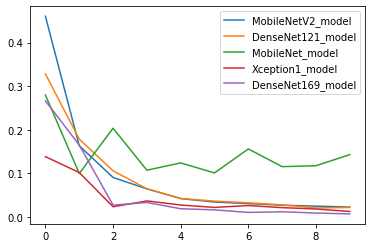

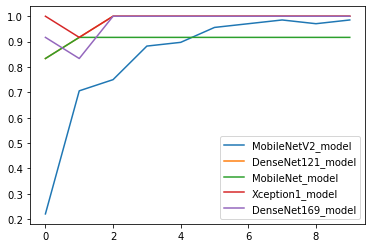

In [169]:
# # testowanie
# y_pred = model.predict(x_test)
# print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
# print(precision_recall_fscore_support(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

plt.plot(history_4.history["val_loss"])
plt.plot(history_5.history["val_loss"])
plt.plot(history_6.history["val_loss"])
plt.plot(history_7.history["val_loss"])
plt.plot(history_8.history["val_loss"])
plt.legend(['MobileNetV2_model','DenseNet121_model','MobileNet_model','Xception1_model','DenseNet169_model'])
plt.show()

plt.plot(history_4.history["val_accuracy"])
plt.plot(history_5.history["val_accuracy"])
plt.plot(history_6.history["val_accuracy"])
plt.plot(history_7.history["val_accuracy"])
plt.plot(history_8.history["val_accuracy"])
plt.legend(['MobileNetV2_model','DenseNet121_model','MobileNet_model','Xception1_model','DenseNet169_model'])
plt.show()

In [170]:
history_4.history['val_loss']

[0.4603583812713623,
 0.1633605659008026,
 0.09054487943649292,
 0.06437461823225021,
 0.04210776835680008,
 0.03416687622666359,
 0.03058185987174511,
 0.0268053337931633,
 0.02474932186305523,
 0.022639060392975807]

In [171]:
fig = go.Figure()

# fig.add_trace(go.Scatter(y=history_1.history['val_loss'],mode='lines',name='model_1'))
# fig.add_trace(go.Scatter(y=history_2.history['val_loss'],mode='lines',name='modelCNN'))
# fig.add_trace(go.Scatter(y=history_3.history['val_loss'],mode='lines',name='modelCnn_2'))
fig.add_trace(go.Scatter(y=history_4.history['val_loss'],mode='lines',name='MobileNetV2_model'))
fig.add_trace(go.Scatter(y=history_5.history['val_loss'],mode='lines',name='DenseNet121_model'))
fig.add_trace(go.Scatter(y=history_6.history['val_loss'],mode='lines',name='MobileNet_model'))
fig.add_trace(go.Scatter(y=history_7.history['val_loss'],mode='lines',name='Xception1_model'))
fig.add_trace(go.Scatter(y=history_8.history['val_loss'],mode='lines',name='DenseNet169_model'))
# px.line(history_5.history, y=history_5.history['val_loss'],labels={'DenseNet121_model'}, title='Training History')


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'lines',
              'name': 'MobileNetV2_model',
              'type': 'scatter',
              'y': [0.4603583812713623, 0.1633605659008026, 0.09054487943649292,
                    0.06437461823225021, 0.04210776835680008, 0.03416687622666359,
                    0.03058185987174511, 0.0268053337931633, 0.02474932186305523,
                    0.022639060392975807]},
             {'mode': 'lines',
              'name': 'DenseNet121_model',
              'type': 'scatter',
              'y': [0.32794222235679626, 0.17855723202228546, 0.105804942548275,
                    0.06470263749361038, 0.04236368462443352, 0.03629516437649727,
                    0.0323699451982975, 0.027782849967479706, 0.020524397492408752,
                    0.021762115880846977]},
             {'mode': 'lines',
              'name': 'MobileNet_model',
              'type': 'scatter',
              'y': [0.27971652150154114, 0.09962183237075806, 0.20343941450119019,
                    0.10717042535543442, 0.12390904873609543, 0.10095039010047913,
                    0.1560005098581314, 0.11537400633096695, 0.11739426106214523,
                    0.1429954171180725]},
             {'mode': 'lines',
              'name': 'Xception1_model',
              'type': 'scatter',
              'y': [0.13821834325790405, 0.10184048861265182, 0.02331608533859253,
                    0.03672662749886513, 0.02735372632741928, 0.021814042702317238,
                    0.02614760957658291, 0.02124704420566559, 0.01822553388774395,
                    0.012448570691049099]},
             {'mode': 'lines',
              'name': 'DenseNet169_model',
              'type': 'scatter',
              'y': [0.2663431763648987, 0.1649150252342224, 0.027142338454723358,
                    0.033136557787656784, 0.01880173198878765, 0.0162340234965086,
                    0.010347376577556133, 0.011809433810412884, 0.008949582464993,
                    0.006916765123605728]}],
    'layout': {'template': '...'}
})

# Model DenseNet121 dla wszytkich danych, które posiadamy

In [172]:
# wszystkie zdjecia w takim samym rozmiarze
x = []
for i in range(len(data_df.path)):
    img = plt.imread(data_df.path[i])
    img = cv2.resize(img, (224,224))
    x.append(img)
x = np.array(x)
y = np.array(data_df['label'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
# transformujemy y_test
y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()
# podglądamy
y_test = y_test.astype(np.float32)

# transformujemy y_train
y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1)).toarray()
# podglądamy
y_train = y_train.astype(np.float32)

print("y_test.shape: ", y_test.shape)
print("y_train.shape: ", y_train.shape)
x_test = x_test.reshape(-1,224,224,3)
x_train = x_train.reshape(-1,224,224,3)

y_test.shape:  (1233, 3)
y_train.shape:  (4928, 3)


In [176]:
x_train.shape[0]%190

178

In [177]:
# wejście
inputLayer = tf.keras.Input(shape=(x_train.shape[1:]))

In [178]:
DenseNet121_model = tf.keras.applications.DenseNet121(weights='imagenet',input_shape=x_train.shape[1:],include_top=False)
DenseNet121_model.trainable = False

In [179]:
m = DenseNet121_model(inputLayer, training=False)
m = layers.GlobalAveragePooling2D()(m)
m = layers.Dropout(0.2)(m)
output = layers.Dense(3)(m)
DenseNet121_model = tf.keras.Model(inputLayer, output)
DenseNet121_model.summary()
# kompilujemy całość
DenseNet121_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"],)
# trening z podaniem callbacków
history_5 = DenseNet121_model.fit(x=x_train,y=y_train,batch_size=190,epochs=10,validation_split=0.05)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_16  (None, 1024)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/10
25/25 [==============================] - 159s 6s/step - loss: 0.3949 - accuracy: 0.8272 - val_loss:

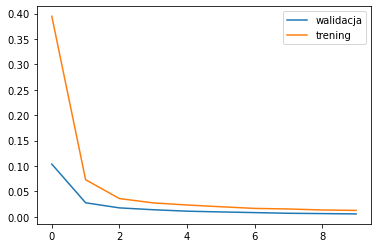

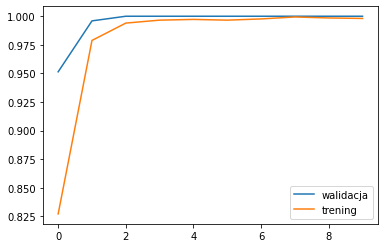

In [180]:
plt.plot(history_5.history["val_loss"])
plt.plot(history_5.history["loss"])
plt.legend(['walidacja','trening'])
plt.show()

plt.plot(history_5.history["val_accuracy"])
plt.plot(history_5.history["accuracy"])
plt.legend(['walidacja','trening'])
plt.show()

In [181]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=history_5.history['val_loss'],mode='lines',name='val loss'))
fig.add_trace(go.Scatter(y=history_5.history['loss'],mode='lines',name='trengng loss'))
fig.add_trace(go.Scatter(y=history_5.history['val_accuracy'],mode='lines',name='val accuracy'))
fig.add_trace(go.Scatter(y=history_5.history['accuracy'],mode='lines',name='trening accuracy'))

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'lines',
              'name': 'val loss',
              'type': 'scatter',
              'y': [0.10373139381408691, 0.027551470324397087,
                    0.017499379813671112, 0.01384311355650425,
                    0.010995235294103622, 0.00953571405261755,
                    0.008216200396418571, 0.00688517838716507,
                    0.006247560027986765, 0.005620576441287994]},
             {'mode': 'lines',
              'name': 'trengng loss',
              'type': 'scatter',
              'y': [0.3948729932308197, 0.07299132645130157, 0.03583256155252457,
                    0.027336878702044487, 0.02316564880311489,
                    0.019729606807231903, 0.016460685059428215,
                    0.01533601339906454, 0.013344771228730679,
                    0.012529818341135979]},
             {'mode': 'lines',
              'name': 'val accuracy',
              'type': 'scatter',
              'y': [0.9514170289039612, 0.9959514141082764, 1.0, 1.0, 1.0, 1.0,
                    1.0, 1.0, 1.0, 1.0]},
             {'mode': 'lines',
              'name': 'trening accuracy',
              'type': 'scatter',
              'y': [0.8271737098693848, 0.9788506627082825, 0.9940183758735657,
                    0.9965819120407104, 0.9972228407859802, 0.9965819120407104,
                    0.9976500868797302, 0.999359130859375, 0.9985045790672302,
                    0.9980773329734802]}],
    'layout': {'template': '...'}
})

In [204]:
# y_pred = DenseNet121_model.predict(x_test)
y_pred = tf.nn.softmax(DenseNet121_model.predict(x_test)).numpy().argmax(axis=1)

In [205]:
y_pred

array([2, 2, 0, ..., 0, 2, 0], dtype=int64)

In [206]:
y_test.argmax(axis=1)

array([2, 2, 0, ..., 0, 2, 0], dtype=int64)

In [207]:
print(classification_report(y_test.argmax(axis=1),y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       485
           1       1.00      1.00      1.00       138
           2       1.00      1.00      1.00       610

    accuracy                           1.00      1233
   macro avg       1.00      1.00      1.00      1233
weighted avg       1.00      1.00      1.00      1233



In [209]:
# warnings.filterwarnings("ignore")

# plt.rcParams["figure.figsize"]=(20,10)
# plot_roc_curve(DenseNet121_model, x_test.argmax(axis=1), y_test)